# Separating MNIST digits using Optimal Transport 

In this post, I'm going to explain how to use the [Optimal Transport](https://en.wikipedia.org/wiki/Transportation_theory_(mathematics)) distance (a generalization of the _Earth mover's distance_) to build a classifier on top of MNIST images. This post borrows heavily from Marco Cuturi's 2013 NeurIPS paper titled [Sinkhorn Distances: Lightspeed Computation of Optimal Transport](https://papers.nips.cc/paper/2013/hash/af21d0c97db2e27e13572cbf59eb343d-Abstract.html). I recommend that you check it out for more detailed discussion and proofs of key results.

In [3]:
using BenchmarkTools
using Distributions
using GLPK
using JuMP
using LIBSVM
using LinearAlgebra
using Metalhead
using MLDatasets
using MLJ
using Plots

In [4]:
train_x, train_y = MNIST.traindata();

## Interpreting MNIST as a distribution over pixels
We can think of every MNIST image as being a distribution over the pixels in the image, so long as we normalize each MNIST digit so that sum of the pixel intensities is 1. Why does thinking of MNIST digits as distributions help us?

If we think of MNIST in this way, then we can think of defining a novel _kernel_ that is based on the _optimal transport distance_ between two different probability distributions.

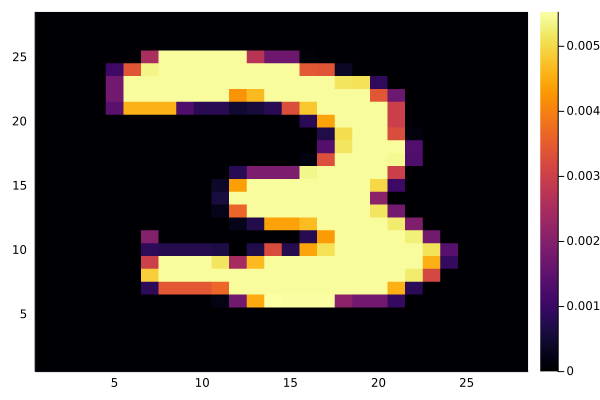

In [5]:
heatmap(normalize(train_x[:, :, 28], 1)')

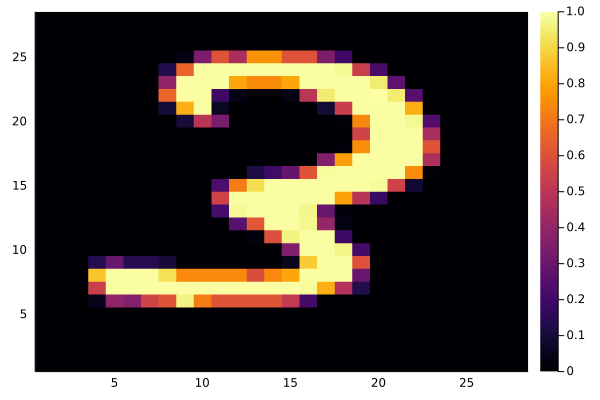

In [6]:
heatmap(train_x[:, :, 13]' / 1.0)

It's helpful to think of these distributions as actually specifying mounds of sand that are piled up to form the MNIST digit. To illustrate this, rather than displaying the MNIST digit in the usual way, we can plot it as a surface in 3D. In this representation, we can intuit the idea of an MNIST digit being a pile of dirt distributed over a 28 pixel by 28 pixel grid.

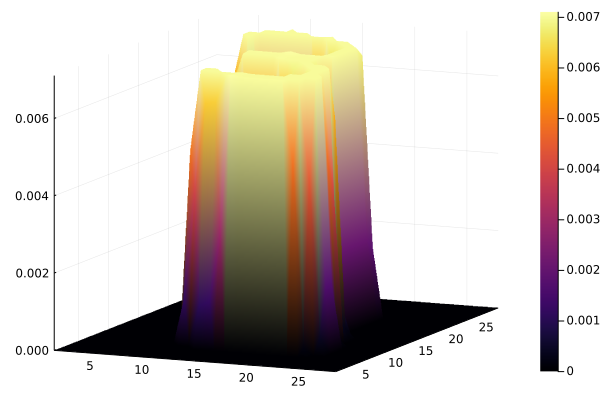

In [7]:
surface(1:28, 1:28, normalize(train_x[:, :, 8], 1)')

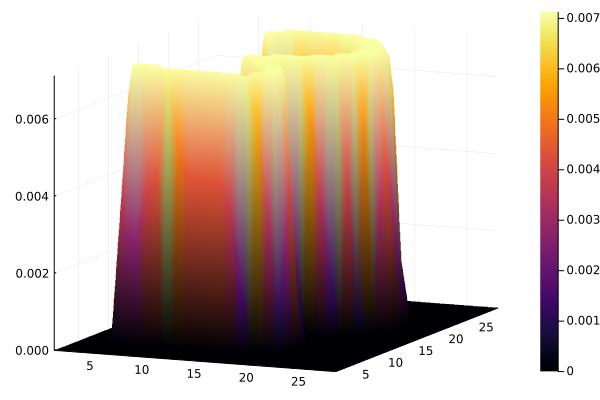

In [8]:
surface(1:28, 1:28, normalize(train_x[:, :, 13], 1)')

Now we can express the intuition behind optimal transport. If I were to give you these two piles of sand that corresponded to these two "three" images in MNIST, and asked you to move the sand from one to the other, then presumably this wouldn't be too hard, since _most_ of the sand is in _mostly_ the right place. However, If I asked you to transform one of the above threes into, say, a six, then you could imagine that being much harder, since almost none of the sand starts out close to where it should go. 

Additionally, if you think about it, this is also why we have to normalize over the sum of the intensities. It's because if we are going to transform one digit into another, then we need the same amount of sand in both! Otherwise we may end up in situation where we have a digit that simply has more sand than another, and therefore (by conservation of mass) we can't transform between them.

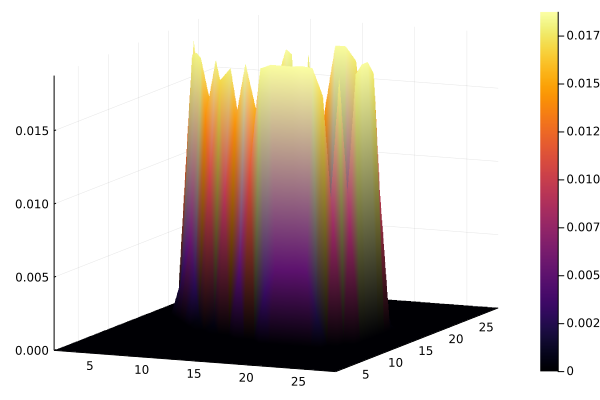

In [9]:
surface(1:28, 1:28, normalize(train_x[:, :, 19], 1))

What we are recognizing here is that there is a natural notion of _distance_ between probability distributions defined on a 28 by 28 grid, and this distance depends on our notion of distance in 2D space. It's intuitively harder to move a three into a six, whereas transforming between two similarly shaped threes should be easier. Let's look at formalizing this notion of a "distance" between probability distributions.

# Defining a distance on probability distributions

Let's call our distance metric $d(P, Q)$. In order to be a valid distance metric, we need to have the following:
0. Any distribution should be 0 distance from itself: $d(P, P) = 0$
1. Symmetry: For any two distributions, $P, Q$, the distance between $P$ and $Q$ should equal the distance between $Q$ and $P$. In other words, we need to have $d(P, Q) = d(Q, P)$.
2. Triangle inequality: For any three distributions $X, Y, Z$, we must have that $d(X, Z) \leq d(X, Y) + d(Y, Z)$. This builds on our intuition that, forcing us to hit an additional point $Y$ along the path between $X$ and $Z$ can only increase the total distance that we have to travel.

The _optimal transport_ distance is the distance induced by a distance metric $M$ (subject to the same constraints listed above) on the underlying support of the probability distributions. For example, if the support of $P, Q$ are on a finite set (i.e $P, Q$ are multinomial distributions, and can be thought of as normalized vectors in $\mathbb{R}^n$), then $M$ will be a matrix associating a distance between each $i$ and $j$ in the support of $P, Q$ respectively. It is called the optimal transport distance because it is minimal amount of "cost" that you would incur if you had to transport each region of support in $P$ to $Q$ at a rate specified by $M$. For finite distributions, we can define the optimal transport distance as

$$
d_M(P, Q) = \min_{T \in U(P, Q)}{\sum_{i, j}{T_{ij}M_{ij}}}
$$

Where $U(P, Q)$ is the _optimal transport polytope_, which is the set of matrices whose rows will sum to $P$ and whose columns will sum to $Q$; or

$$
U(P, Q) = \{ T \in R_{n \times m } \mid\; T\mathbb{1}_m = P,\; T^T\mathbb{1}_n = Q \}
$$

Note: This can also be thought of as the set of two-variable joint probability distributions that have marginals $P$ and $Q$ respectively. This should make it clear that at least one element of $U(P, Q)$ always exists: $PQ^T$, which is the joint distribution which makes each of the two random variables independent. Additionally, $T_{i,j}$ can be interpreted as how much sand we have to move from $i$ to $j$.

Finding this distance is simply finding the objective value for a linear program with variables $T_{ij}$ and whose minimization objective is

$$
\min_{T_{ij}}\sum_{ij}T_{ij}M_{ij}
$$

subject the constraints:

$$
\sum_{j}T_{ij} = P_i
$$

$$
\sum_{i}T_{ij} = Q_i
$$

$$
T_{ij} \geq 0
$$

We can model this in Julia as a simple linear program in JuMP.

In [10]:
function linear_program(M, p, q)
    n = length(p)
    m = length(q)

    model = Model(GLPK.Optimizer)
    @variable(model, T[1:n, 1:m])
    @constraint(model, sum(T; dims=1)' .== q)
    @constraint(model, sum(T; dims=2) .== p)
    @constraint(model, T .>= 0.)
    @objective(model, Min, sum(T .* M))
    
    return model
end

function d_M(M, p, q)
    model = linear_program(M, p, q)
    optimize!(model)
    
    return objective_value(model)
end

d_M (generic function with 1 method)

In order to test it, we can sample two multinomial distributions from a Dirichlet.

In [11]:
dirichlet_5 = Dirichlet(5, 0.5)

p, q = rand(dirichlet_5), rand(dirichlet_5);

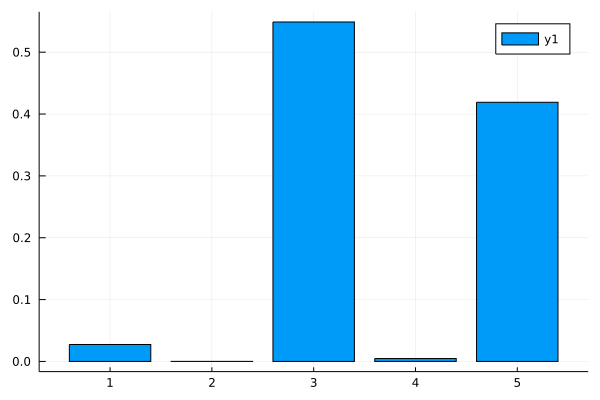

In [12]:
bar(p)

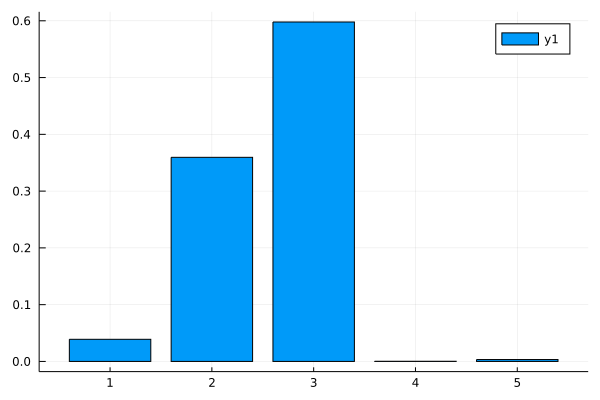

In [13]:
bar(q)

However, we still need to come up with a distance among the values $1..5$. A simple case is to take $M_{ij} = |i - j|$. This corresponds to saying that the "cost" of moving $x$ amount of sand from, say, bin $2$ to bin $3$ is $x$, but from bin $2$ to bin $4$ is $2x$, and so on. This will result in the standard _Earth mover's distance_, but it's important to note that we could have chosen other cost matrices, which correspond to alternative geometries on the underlying space. The following generates this matrix in Julia for the $1..5$ case:

In [14]:
M = reshape([ abs(i - j) for i in 1:length(p) for j in 1:length(q) ], (length(p), length(q)))

5×5 Matrix{Int64}:
 0  1  2  3  4
 1  0  1  2  3
 2  1  0  1  2
 3  2  1  0  1
 4  3  2  1  0

Now, to calculate the optimal transport solution, we need to solve the following linear program

In [15]:
linear_program(M, p, q)

A JuMP Model
Minimization problem with:
Variables: 25
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 10 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 25 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: GLPK
Names registered in the model: T

Note that all of the elements of the resulting matrix need to be positive, and that all of the rows and columns of the matrix are constrained to sum to the values in $P$ and $Q$. Now we can solve linear program to obtain the optimal transport distance, induced by the metric $M$, between $P$ and $Q$

In [16]:
d_M(M, p, q)

1.2183665086601567

To check our work, we can verify that it costs nothing to move a distribution of sand to itself

In [17]:
d_M(M, p, p)

0.0

In [18]:
d_M(M, q, q)

0.0

Also, we can verify that moving all of the sand from the first to the second location costs 1 unit

In [19]:
d_M(M, [1, 0, 0, 0, 0], [0, 1, 0, 0, 0])

1.0

However, moving all of the earth from the first to the last location costs at least $|5 - 1| = 4$ units

In [20]:
d_M(M, [1, 0, 0, 0, 0], [0, 0, 0, 0, 1])

4.0

Lastly, we can interpolate between our two distributions linearly and plot the distance between them as they grow apart

In [21]:
interpolate(p, q; α) = normalize((1-α).*p .+ α.*q, 1)

interpolate (generic function with 1 method)

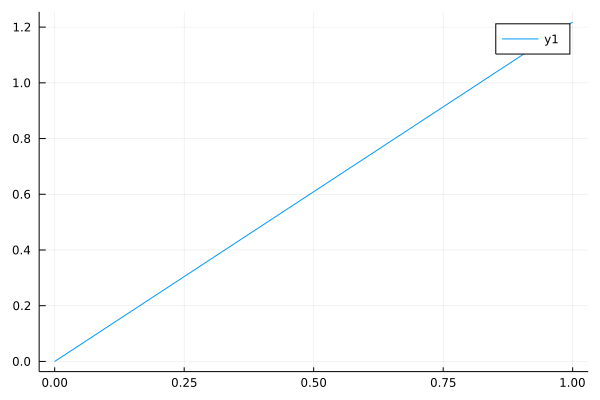

In [22]:
plot(0:0.01:1, α -> d_M(M, p, interpolate(p, q; α=α)))

<b>Side note:</b> we can plot the interpolation from distribution into another in this way:

┌ Info: Saved animation to 
│   fn = /Users/maxwellrussek/code/notebooks/tmp.gif
└ @ Plots /Users/maxwellrussek/.julia/packages/Plots/SVksJ/src/animation.jl:104


Plots.AnimatedGif("/Users/maxwellrussek/code/notebooks/tmp.gif")
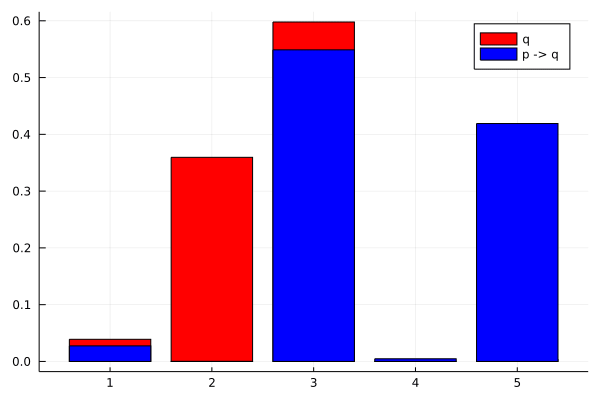

In [23]:
@gif for α in 0:0.01:1
    bar(q; color="red", label="q")
    bar!(interpolate(p, q; α=α), color="blue", label="p -> q")
end

## Scaling to MNIST

Can we scale this up to distributions the size of MNIST images? In order to do so, we will need to be able to support distributions of $\sim 28\times28 \approx 700$ "buckets".

We will also need a different distance matrix from before. In the above case, our distance metric was essentially _one dimensional_ since it needed to compute the distance between two pairs of points on the line. Here, however, we have two points on the plane, so we need to consider if we want to choose the Euclidean distance or some other distance metric (e.g the _Manhattan distance_ between pixels). Here we choose the Euclidean metric for simplicity.

In [24]:
M_mnist = zeros(28*28, 28*28)
# i: Row index of first pixel
# j: Column index of first pixel
# k: Row index of second pixel
# l: Column index of second pixel
for i in 1:28, j in 1:28, k in 1:28, l in 1:28
    M_mnist[28 * (i-1) + j, 28 * (k-1) + l] = sqrt((i - k)^2 + (j - l)^2)
end

We can confirm that this distance matrix makes sense in terms of the distance between various pixels.

In [25]:
# distance between (3, 1) and (4, 2) is √2
M_mnist[28*2 + 1, 28*3 + 2] ≈ sqrt(2)

true

In [26]:
# distance between (3, 2) and (11, 2) is 8
M_mnist[28*2 + 2, 28*10 + 2] ≈ 8.0

true

Alas, even with a relatively fast linear program solver (GLPK), this is far too slow:

In [27]:
# THIS WILL NOT RUN, TOO SLOW
# d_M(M_mnist, p_large, q_large)

# Making the Optimal Transport Distance Tractable

It's clear that if we are going to define a kernel over MNIST digits in terms of optimal transport, we will need something that scales better than the actual optimal transport distance.

In order to motivate our solution, we can observe an interesting trend in the optimal transport matrices (joint distributions) that are selected by our technique.

In [28]:
function solution_matrix(M, p, q)
    n = length(p)
    m = length(q)

    model = Model(GLPK.Optimizer)
    @variable(model, T[1:n, 1:m])
    @constraint(model, sum(T; dims=1)' .== q)
    @constraint(model, sum(T; dims=2) .== p)
    @constraint(model, T .>= 0.)
    @objective(model, Min, sum(T .* M))
    optimize!(model)
    
    return JuMP.value.(T)
end

solution_matrix(M, rand(dirichlet_5), rand(dirichlet_5))

5×5 Matrix{Float64}:
 0.058264  0.215273  0.432834   0.0        0.0
 0.0       0.0       0.0647211  0.12835    0.0
 0.0       0.0       0.0        0.0892647  0.00538129
 0.0       0.0       0.0        0.0        0.00567185
 0.0       0.0       0.0        0.0        0.000239382

One thing we may be able to see after seeing a number of solution matrices is that they tend to be sparse, meaning that most of the elements are zero. In fact, it can be shown that any solution of an optimal transport problem will have up to $2d - 1$ non-zero elements, where $d$ is the size of the underlying marginal distributions.

In [29]:
sum(solution_matrix(M, rand(dirichlet_5), rand(dirichlet_5)) .≉ 0.0) == (2*5 - 1)

true

This should make some intuitive sense if you are familiar with the [fundamental theorem of linear programming](https://en.wikipedia.org/wiki/Fundamental_theorem_of_linear_programming) which states that any optimum value of a linear function over a polytope region will lie on a vertex of that polytope. In this case, the vertices of our polytope will tend to have many zero values due to our several non-negativity constraints (i.e $T_{i,j} \ge 0$).

Another way of thinking of this is that the joint distributions $T_{ij}$ that we find when solving the optimal transport problem have _low entropy_, defined as:

$$
H(T) = \sum_{i,j}{T_{ij}\log{T_{ij}}}
$$

This suggests that we could significantly narrow our search space by considering only matrices that meet a certain entropy minimum.

$$
U_C(P, Q) = \{ \; T \in U(P, Q) \; | \;  H(T) \ge C \; \}
$$

However, there is already a natural _maximum entropy_ that can be contained in $T$ when $P, Q$ are fixed: the entropy of the independent distribution $PQ^T$.

$$
H(T) \le H(P) + H(Q) = H(PQ^T)
$$

We can alternately define our constraint by ensuring the entropy of the joint distribution does not fall too far below the maximum entropy:

$$
U_\alpha(P, Q) = \{ \; T \in U(P, Q) \; | \;  H(T) \ge H(P) + H(Q) - \alpha \; \}
$$

We can characterize $\alpha$ in the equation above as how much entropy we are allowed to sacrifice relative to the independent distribution in order to find a solution.

Now, with this constraint, we can define the _Sinkhorn_ distance as the minimum cost over this new region of joint distributions:

$$
d_{\alpha,M}(P, Q) = \min_{T \in U_\alpha(P, Q)}{\sum_{i, j}{T_{ij}M_{ij}}}
$$

With a great deal of effort not expended here, one can prove that $d_{\alpha,M}$ satisfies our criteria for distance metrics described above. Furthermore, we can substitute the above _hard constraint_ on entropy with a _soft constraint_ (akin to a regularizer) on entropy. In particular, for each $\alpha > 0$ we can show that there is a $\lambda > 0$ such that:

$$
\forall P, Q \in \mathbb{R}^d,\; d_{\alpha,M}(P, Q) = d^\lambda_M(P, Q)\\
\mathrm{Where} \quad
d^\lambda_M(P, Q) = \min_{T \in U_\alpha(P, Q)}{\sum_{i, j}{T_{ij}M_{ij}} - \frac{1}{\lambda}H(T)}
$$

How does any of this help us? Well, as it turns out, we can compute $d^\lambda_M(P, Q)$ efficiently using an iterative scaling matrix algorithm, given below in Julia:

In [30]:
function sinkhorn_plan(M, p, q; λ=1e1, rounds=2)
    K = exp.(-M .* λ)
    v = one.(q)
    u = p ./ (K * v)
    v = q ./ (K' * u)
    for _ in 1:rounds
        u = p ./ (K * v)
        v = q ./ (K' * u)
    end
    T_λ = u .* K .* v'
    sum(T_λ .* M)
end

sinkhorn_plan (generic function with 1 method)

To verify our implementation, we can compare it with the true linear program result on our small distributions

In [31]:
sinkhorn_plan(M, p, q; rounds=100)

1.2183665121297167

In [32]:
d_M(M, p, q)

1.2183665086601567

Now, we can see that we can compute the distance between large histograms in a fraction of the time!

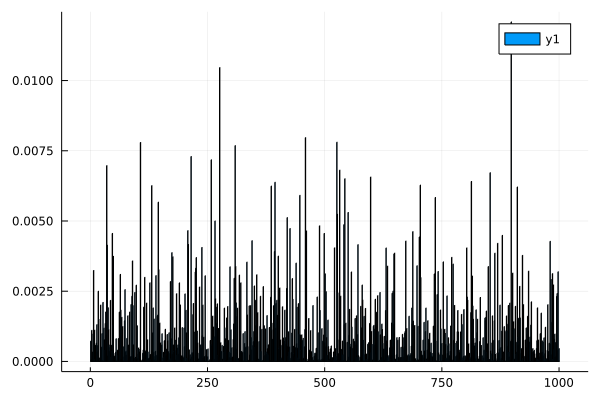

In [33]:
d_large = Dirichlet(1000, 0.5)
p_large, q_large = rand(d_large), rand(d_large)

bar(p_large)

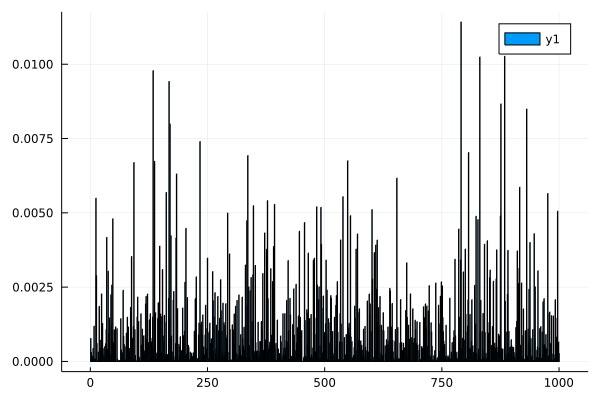

In [34]:
bar(q_large)

In [35]:
M_large = reshape([ abs(i - j) for i in 1:length(p_large) for j in 1:length(q_large) ], (length(p_large), length(q_large)))

@btime sinkhorn_plan(M_large, p_large, q_large; rounds=1000, λ=1e1)

  266.335 ms (4014 allocations: 61.56 MiB)


5.452673062243009

# Computing the distance between two MNIST digits

Now we can actually start computing our distances between actual MNIST digits! We'll start with the two threes and the six from above

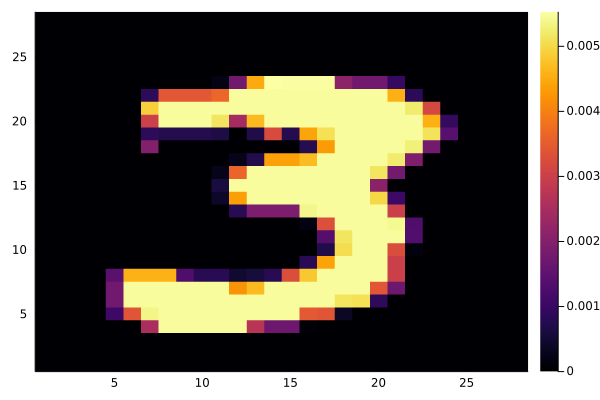

In [36]:
three_1 = normalize(train_x[:, :, 28], 1)
three_2 = normalize(train_x[:, :, 13], 1)
six = normalize(train_x[:, :, 33], 1)
heatmap(three_1[:,end:-1:1]')

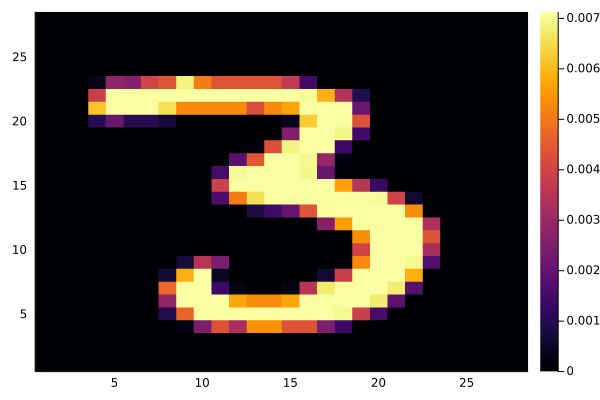

In [37]:
heatmap(three_2[:,end:-1:1]')

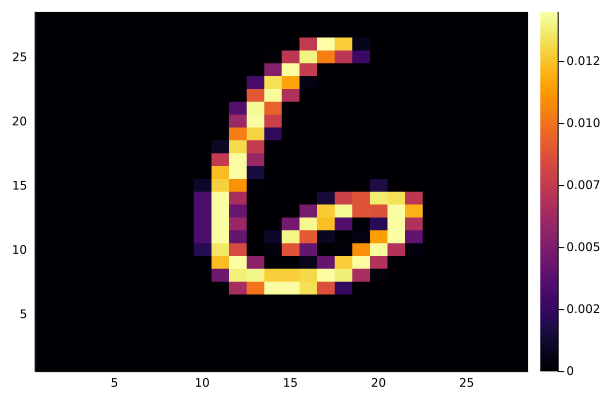

In [38]:
heatmap(six[:,end:-1:1]')

Now, the distance between the two "three" images is

In [39]:
p_mnist = reshape(three_1, (28*28));
q_mnist = reshape(three_2, (28*28));

sinkhorn_plan(M_mnist, p_mnist, q_mnist; rounds=1000)

2.2481722126487464

In [40]:
sinkhorn_plan(M_mnist, q_mnist, p_mnist; rounds=1000)

2.2481690687793945

while the distance between the first three and the six is

In [41]:
p_mnist = reshape(three_1, (28*28));
q_mnist = reshape(six, (28*28));

sinkhorn_plan(M_mnist, p_mnist, q_mnist; rounds=1000)

2.9099664419903144

Exactly as we suspected! The three is further from the six than from the other three. This distance metric _should_ provide us with a good way of building a kernel classifier on top of MNIST.

## MNIST Support Vector Machine
So now that we have our distance between distributions, we can use this to build a classifier. The first step in doing this is to convert from the _distance metric_ to a _kernel_, which is in some sense the opposite of a distance metric. Where the distance metric starts at zero when the two points are the same and increases as the points move further away from one another, the kernel obtains its maximum value at when the points are the same and _decreases_ as the points are separated. As an example, in $\mathbb{R}^n$ with the Euclidean distance, we have

$$
d(\mathbf{x}, \mathbf{y}) = \sum_{i=0}^n{(x_i - y_i)^2}
$$

While the classic RBF kernel used in kernel methods is

$$
k(\mathbf{x}, \mathbf{y}) = e^{-d(\mathbf{x}, \mathbf{y})}
$$

Similarly, we will need to convert each of our pairwise distances in MNIST $d_M(P, Q)$ into a kernel value $k_M(P, Q)$. We can do this in a similar way to the RBF kernel, simply by taking $k_M(P, Q) = e^{-d_M(P, Q)}$. With this kernel, we can train a Support Vector Machine to classify MNIST digits.

In [42]:
k(x, y) = exp(-sinkhorn_plan(M_mnist, x, y))

k (generic function with 1 method)

Our implementation is still not particularly fast so in this post we will limit our consideration to the first 1,000 MNIST images. However, note that it is possible to parallelize the above algorithm to operate on multiple histograms at once (on a GPU as well) in order to scale to the whole dataset.

In [43]:
train_x_small = collect(Float64.(reshape(train_x, (28 * 28, 60_000))[:, 1:1000]'));
train_y_small = train_y[1:1000];

test_x = collect(Float64.(reshape(train_x, (28 * 28, 60_000))[:, 1001:1100]'));
test_y = train_y[1001:1100];

In [42]:
K = Matrix{Float64}(I, 1000, 1000)
for i in 1:1000, j in 1:(i-1)
    p = normalize(train_x_small[i, :], 1)
    q = normalize(train_x_small[j, :], 1)
    
    K[i, j] = k(p, q)
    K[j, i] = K[i, j]
end

Now that we have precomputed our kernel matrix, we can use it to train an MNIST classifier.

In [47]:
model = svmtrain(K, train_y_small; kernel=Kernel.Precomputed);

We can see that this reaches an acceptable (not great) accuracy on the training set

In [48]:
ŷ, _ = svmpredict(model, K)

mean(ŷ .== train_y_small)

0.855

To predict new instances, we have to compute the kernel of each new instance with each of the training instances

In [ ]:
K_test = zeros(1000, 100)
for i in 1:100, j in 1:1000
    K_test[j, i] = k(normalize(test_x[i, :], 1), normalize(train_x_small[j, :], 1))
end

We end up getting some...not so great results.

In [50]:
test_ŷ, = svmpredict(model, K_test)

mean(test_ŷ .== test_y)

0.69

But at least we learned something! 😊

_I'd like to thank [@barucden](https://github.com/barucden), [@ablaom](https://github.com/ablaom), and [iblis17](https://github.com/iblis17) for adding support in LIBSVM.jl for precomputed kernels, as well as [Marco Cuturi](https://marcocuturi.net/) for the original paper and all his work on optimal transport_ 